In [4]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../libs')
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic

np.random.seed(200)

In [5]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [43]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                    #  "wa-sa-A2", "wa-sa-B4",
                                     "wa-sa-C4",
                                    #  "wa-sa-B3",  "wa-sa-B2",
                                    #  "wa-sa-A5", "wa-sa-C5",
                                    #  "wa-sa-A3",
                                    #  "wa-sa-C3", # Pos
                                    #  "wa-sa-D3", # Zero
                                    #  "wa-sa-D4", 
                                    #  "wa-sa-B1", "wa-sa-A4",
                                    #  "wa-sa-A1", "wa-sa-D2",
                                    #  "wa-sa-C5", # Pos
                                    #  "wa-sa-D5", # Zero
                                    #  "wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [44]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.ClusterHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.21,
                                     contamination=0.004,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa)

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0002608929254104543, n_outlier: 101

Total error rate: 7.837442823270832e-05
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000021     0.000036   0.000357   0.000005   0.000052      0.0

Precision (TP / (TP + FP)): 0.9918567625411077
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.998062     0.997261   0.951965    0.99901   0.999244      1.0

Recall / TPR (TP / (TP + FN)): 0.9986335207862511
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.999251   0.997712        1.0   0.995733      1.0

Specificity / TNR (TN / (TN + FP)): 0.9999322669429249
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999979     0.999971   0.999657   0.999995   0.999992      1.0

Accuracy ((TP + TN) / (P + N)): 0.9999216255717673
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999979     0.999964   0.999643   0.999995   0.999948      1.0

F1 (2 * (precision 

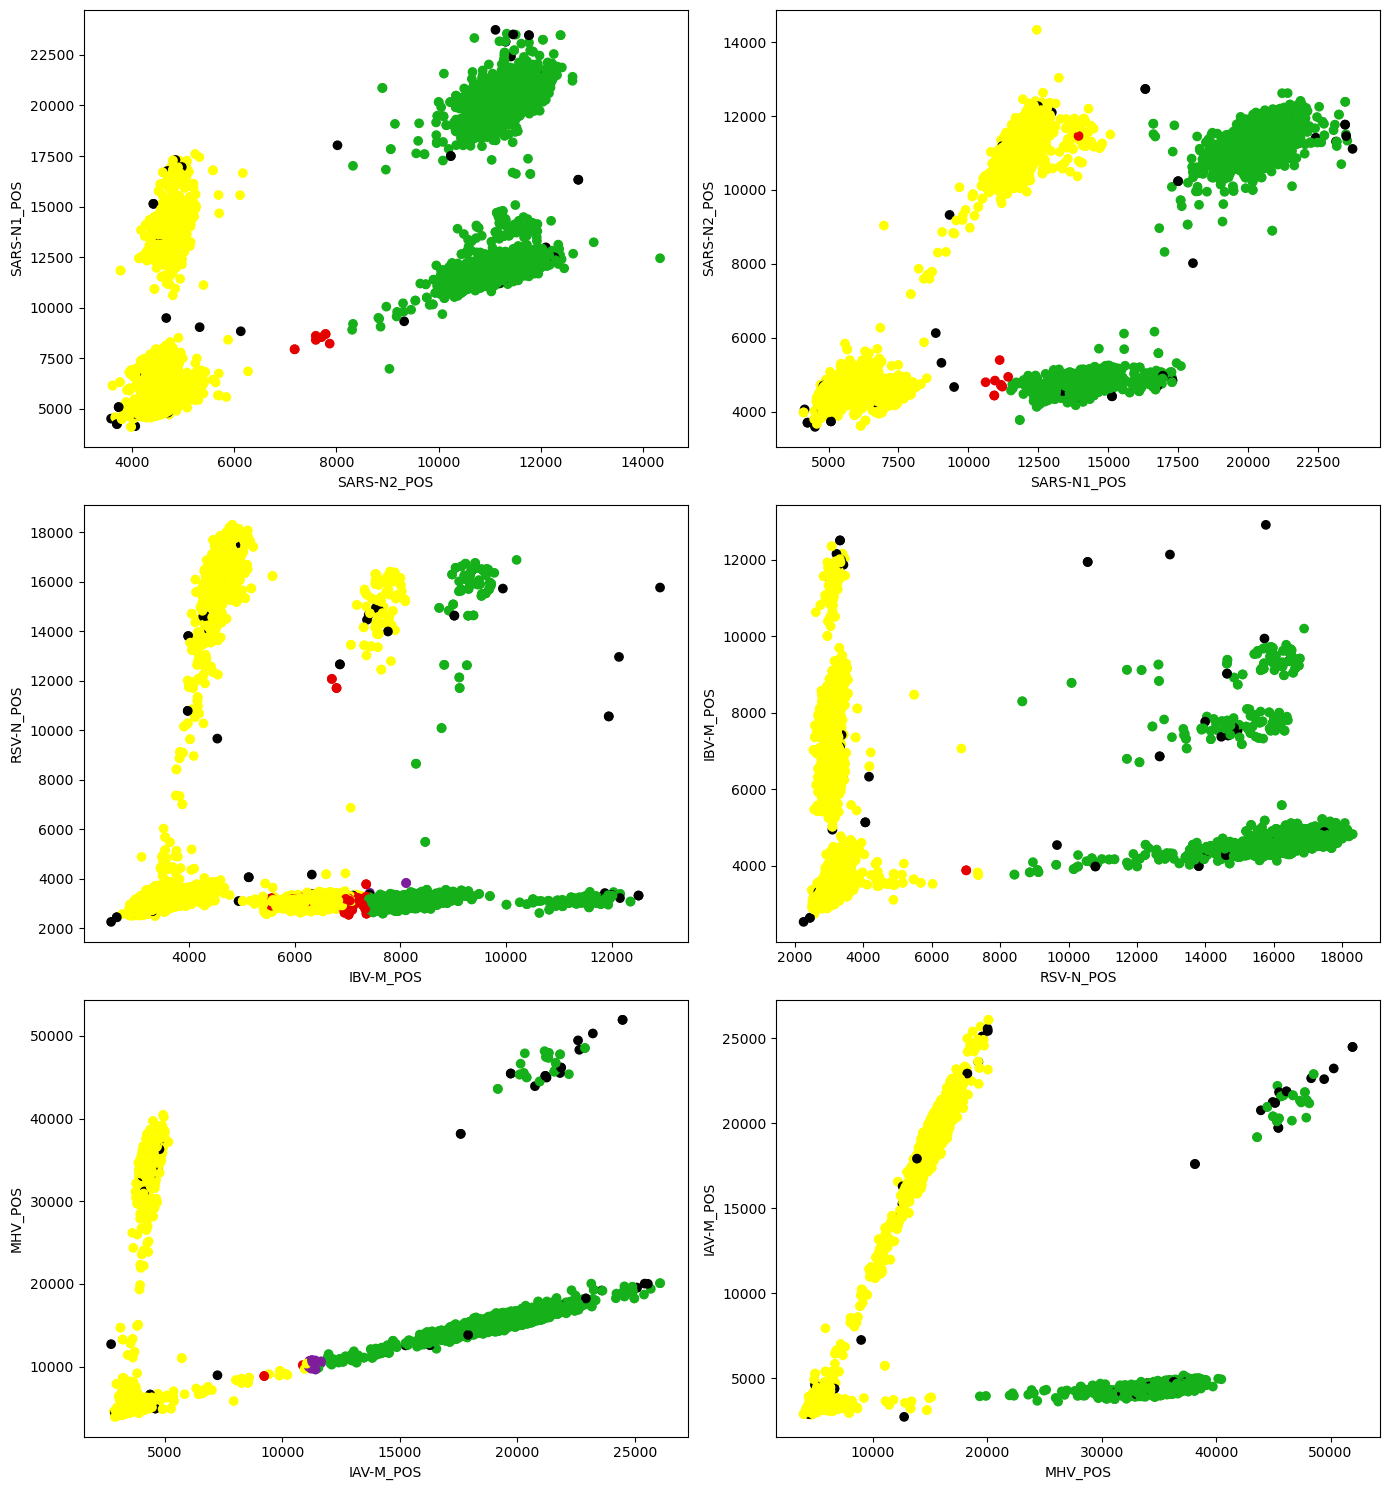

In [45]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )

In [46]:
predicted_percentagees = []
for axis in prediction_axis:
    predicted_percentagees.append((df_predictions > 0.5)[axis].sum() / df_predictions.shape[0])

true_percentages = []
for axis in prediction_axis:
    true_percentages.append(df_wa[axis].sum() / df_predictions.shape[0])

true_log_percentages = [-np.log(1-pct) for pct in true_percentages]
predicted_log_percentages = [-np.log(1-pct) for pct in predicted_percentagees]
print(true_log_percentages)
print(predicted_log_percentages)

[0.010806451846515784, 0.01050621308918084, 0.0068479393395930645, 0.005332793441125678, 0.010495771624034353, 0.006010816808248857]
[0.010720287154403306, 0.010427904757917439, 0.007123667223931859, 0.00523151907189401, 0.01030784389213434, 0.005893883425063904]


In [39]:
df_wa

,Chan1_FluoValue,Chan2_FluoValue,Chan3_FluoValue,Chan4_FluoValue,Chan5_FluoValue,Chan6_FluoValue,IAV-M_POS,IBV-M_POS,MHV_POS,RSV-N_POS,SARS-N1_POS,SARS-N2_POS
0,4763,5451,3742,3201,3930,5479,0,0,0,0,0,0
1,4869,5202,3424,3108,3408,5141,0,0,0,0,0,0
2,4715,5263,3376,3175,3608,4937,0,0,0,0,0,0
3,4261,5082,3396,2971,3268,4676,0,0,0,0,0,0
4,4366,5471,3681,3024,3502,5133,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18945,4531,5236,3332,3106,3533,5201,0,0,0,0,0,0
18946,3385,3888,2863,2376,2873,4100,0,0,0,0,0,0
18947,4501,5183,3348,3078,3527,5078,0,0,0,0,0,0
18948,4735,5510,3531,3348,3473,5414,0,0,0,0,0,0
